# ML Pipeline Preparation
Follow the instructions below to help you create your ML pipeline.
### 1. Import libraries and load data from database.
- Import Python libraries
- Load dataset from database with [`read_sql_table`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_sql_table.html)
- Define feature and target variables X and Y

In [1]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
# load data from database
from sqlalchemy import create_engine
engine = create_engine('sqlite:///data/DisasterResponse.db')
df = pd.read_sql("SELECT * FROM RawDataClean", engine)

In [3]:
df.head(3)

,id,message,original,genre,related,request,offer,aid_related,medical_help,medical_products,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct,1,0,0,1,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### 2. Write a tokenization function to process your text data

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re

stop_words = stopwords.words("english")
lemmatizer = WordNetLemmatizer()

In [5]:
def tokenize(text):
    # normalize case and remove punctuation
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    # tokenize text
    tokens = word_tokenize(text)
    
    # lemmatize andremove stop words
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return tokens

### 3. Build a machine learning pipeline
This machine pipeline should take in the `message` column as input and output classification results on the other 36 categories in the dataset. You may find the [MultiOutputClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) helpful for predicting multiple target variables.

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score
from sklearn.pipeline import Pipeline

In [30]:
base_lr = LogisticRegression(max_iter = 500)
pipe = Pipeline([
    ('tfidf_vect', TfidfVectorizer(tokenizer = tokenize)),
    ('clf', OneVsRestClassifier(base_lr)),
])

### 4. Train pipeline
- Split data into train and test sets
- Train pipeline

In [31]:
from sklearn.model_selection import train_test_split
categories = df.drop(columns = ['id', 'message', 'original', 'genre'])
x, y = df['message'].to_numpy(), categories.to_numpy()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle = True, random_state=0)
x_train.shape, y_train.shape, y.shape, x.shape

((18326,), (18326, 35), (26180, 35), (26180,))

In [34]:
pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)

### 5. Test your model
Report the f1 score, precision and recall for each output category of the dataset. You can do this by iterating through the columns and calling sklearn's `classification_report` on each.

In [35]:
from sklearn.metrics import classification_report

target_names = categories.columns.values
report = classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
report = pd.DataFrame(report).transpose()
report[(report['precision'] == 0.0) | (report.index == 'macro avg')]

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support
offer,0.000000,0.000000,0.000000,41.0
security,0.000000,0.000000,0.000000,132.0
tools,0.000000,0.000000,0.000000,34.0
hospitals,0.000000,0.000000,0.000000,94.0
shops,0.000000,0.000000,0.000000,36.0
aid_centers,0.000000,0.000000,0.000000,88.0
macro avg,0.623246,0.230912,0.296339,24501.0


We see from those anomalous predicted results with precision = recall = 0 all come from the categories where the positive samples are scarce. So the classifier has the tendency to label every message with negative label.

### 6. Improve your model
We first try to use grid search to find better parameters. 

In [12]:
from sklearn.model_selection import GridSearchCV
from shutil import rmtree
from tempfile import mkdtemp
cachedir = mkdtemp()

pipe = Pipeline([
    ('tfidf_vect', TfidfVectorizer(tokenizer = tokenize)),
    ('clf', OneVsRestClassifier(base_lr)),
], memory=cachedir)

## parameters for logistic_regression
parameters = {
    'tfidf_vect__max_df': (0.5, 0.75, 1.0),
    'tfidf_vect__max_features': (None, 5000, 10000),
    'tfidf_vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'clf__estimator__max_iter': (50, 100, 500), 
    'clf__estimator__C': (0.1, 1.0, 10, 100),
}


grid_search = GridSearchCV(pipe, parameters, scoring = 'f1_samples', n_jobs=-1, verbose=1)

In [24]:
from pprint import pprint
from time import time

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipe.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(x_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

rmtree(cachedir)

Performing grid search...
pipeline: ['tfidf_vect', 'clf']
parameters:
{'clf__estimator__C': (0.1, 1.0, 10, 100),
 'clf__estimator__max_iter': (50, 100, 500),
 'tfidf_vect__max_df': (0.5, 0.75, 1.0),
 'tfidf_vect__max_features': (None, 5000, 10000),
 'tfidf_vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 216 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 328 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done 828 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:   12.6s finished
/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/pipeline.py:315: UserWarning: Persisting input arguments took 2.52s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name])


done in 23.065s

Best score: nan
Best parameters set:
	clf__estimator__C: 0.1
	clf__estimator__max_iter: 50
	tfidf_vect__max_df: 0.5
	tfidf_vect__max_features: None
	tfidf_vect__ngram_range: (1, 1)


### 7. Test your model
Show the accuracy, precision, and recall of the tuned model.  

Since this project focuses on code quality, process, and  pipelines, there is no minimum performance metric needed to pass. However, make sure to fine tune your models for accuracy, precision and recall to make your project stand out - especially for your portfolio!

In [14]:
new_pipe = Pipeline([
    ('tfidf_vect', best_parameters['tfidf_vect']),
    ('clf', best_parameters['clf']),
])

In [20]:
new_pipe.fit(x_train, y_train)
y_pred = new_pipe.predict(x_test)
ovr_jaccard_score = jaccard_score(y_test, y_pred, average='samples')
ovr_jaccard_score

/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.3856414411275485

In [22]:
new_report = classification_report(y_test, y_pred, target_names = target_names, output_dict=True)
new_report = pd.DataFrame(new_report).transpose()
new_report[(new_report['precision'] == 0.0) | (new_report.index == 'macro avg')]

,precision,recall,f1-score,support
offer,0.000000,0.000000,0.000000,41.0
medical_help,0.000000,0.000000,0.000000,598.0
medical_products,0.000000,0.000000,0.000000,382.0
search_and_rescue,0.000000,0.000000,0.000000,192.0
security,0.000000,0.000000,0.000000,132.0
military,0.000000,0.000000,0.000000,260.0
clothing,0.000000,0.000000,0.000000,122.0
money,0.000000,0.000000,0.000000,180.0
missing_people,0.000000,0.000000,0.000000,71.0
refugees,0.000000,0.000000,0.000000,237.0


We can see it's actuall getting worse with new parameters found by grid search. We may turn to something else.

### 8. Try improving your model further. Here are a few ideas:
* try other machine learning algorithms
* add other features besides the TF-IDF

### Simple sampling method

As we can see before the dataset is very imbalanced. A lot of categories only have very few labels. Now we try to upsample those sparse samples. It is a little bit tricky though. For example a message may have labels which are both unpopular and popular. 

Now we first use a simple sample strategy by upsampling messages with unpopular labels, regardless of whether the message have popular labels.

In [74]:
# # first we only consider related messages
sub_cats = categories[categories['related'] == 1].drop(columns = 'related')
# counts how many positive labels within each category
label_counts = sub_cats.sum().values
criteria = label_counts/df.shape[0] < 0.05
sparse_label = list(sub_cats.columns[criteria])

Note here we set the number of bootstrap sampling to be equal to the number of messages in the most popular category.

In [75]:
upsample_num = np.sort(label_counts)[::-1][0]
msg_simple_sample = df[df[sparse_label].any(axis = 1)].sample(n = upsample_num, replace = True, random_state = 0)
df_simple_sample = pd.concat([msg_simple_sample, df[~df[sparse_label].any(axis = 1)]])

To simplify the notebook, we import the class ML_classifier which makes model building, testing, and visualization much easier

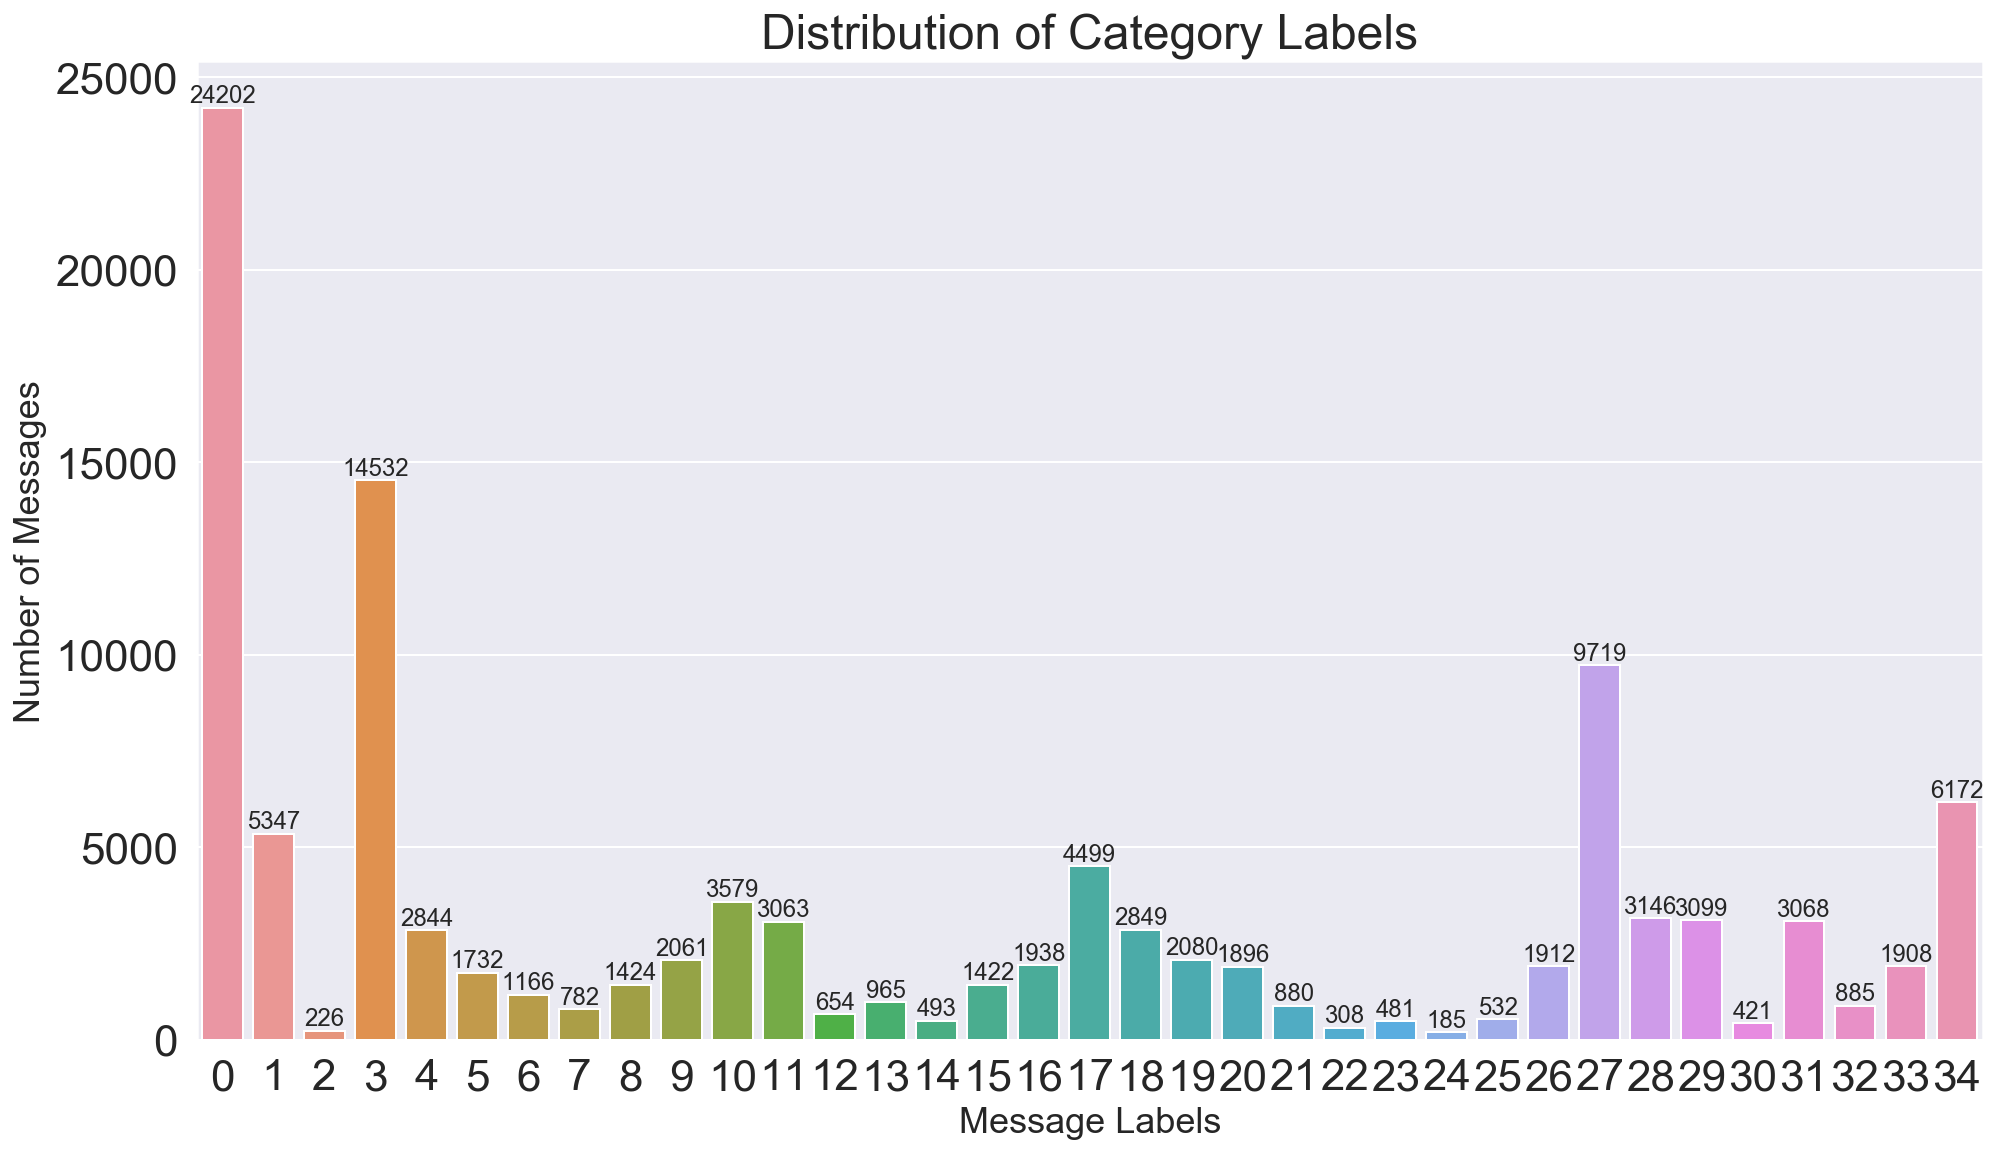

In [76]:
from models.train_classifier import ML_classifier

model_simple_sample = ML_classifier(df_simple_sample)
model_simple_sample.plot_dist()

If we compare carefully, these is indeed some increase of instances within those minority groups. 

In [77]:
model_simple_sample.fit()
model_simple_sample.evaluate()

The Jaccard score on the test data set is: 0.4646238416042611


/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [78]:
report_simple_sample = model_simple_sample.report
report_simple_sample[(report_simple_sample['precision'] == 0.0) | (report_simple_sample.index == 'macro avg')]

,precision,recall,f1-score,support
offer,0.000000,0.000000,0.000000,42.0
tools,0.000000,0.000000,0.000000,58.0
shops,0.000000,0.000000,0.000000,41.0
macro avg,0.757558,0.299667,0.387004,21808.0


We can see an impressive improvement of our model by using this simple upsampling trick. The number of categories with f1-score = 0 also decreases.

### More Sophiscated Resample Strategy

We can still make progress by using a more sophiscated sampling method, i.e., only upsampling the messages with unpopular labels.

In [79]:
# we define the top-3 most labels as popular
pop_label = list(sub_cats.sum().sort_values(ascending = False)[:3].index)
# messages without any label in those popular categories 
sparse_msg = sub_cats[~sub_cats[pop_label].any(axis = 1)]
sparse_msg.sum(axis = 1).value_counts()

0    5115
1     247
2      81
3      29
4       3
5       2
dtype: int64

We see most messages actually don't get any labels. Since we want to improve our f1 score, we need to put more postive samples in our dataset. So we will only up-sample messages with at least 1 positive label within the unpopular groups.

In [80]:
# messages to be upsampled
# we exclude messages without any labels other than 'related' = 1
msg_to_sample = sparse_msg[(sparse_msg.sum(axis = 1) > 0)]

Here we again use the same up-sampling number.

In [81]:
# upsampling 
# msg_under_sample = msg_to_sample.sample(n = label_counts[0], replace = True, random_state = 0)
msg_under_sample = msg_to_sample.sample(n = upsample_num, replace = True, random_state = 0)
df_sample = pd.concat([df.loc[msg_under_sample.index], df.loc[list(set(df.index.values) - set(msg_to_sample.index.values))]])

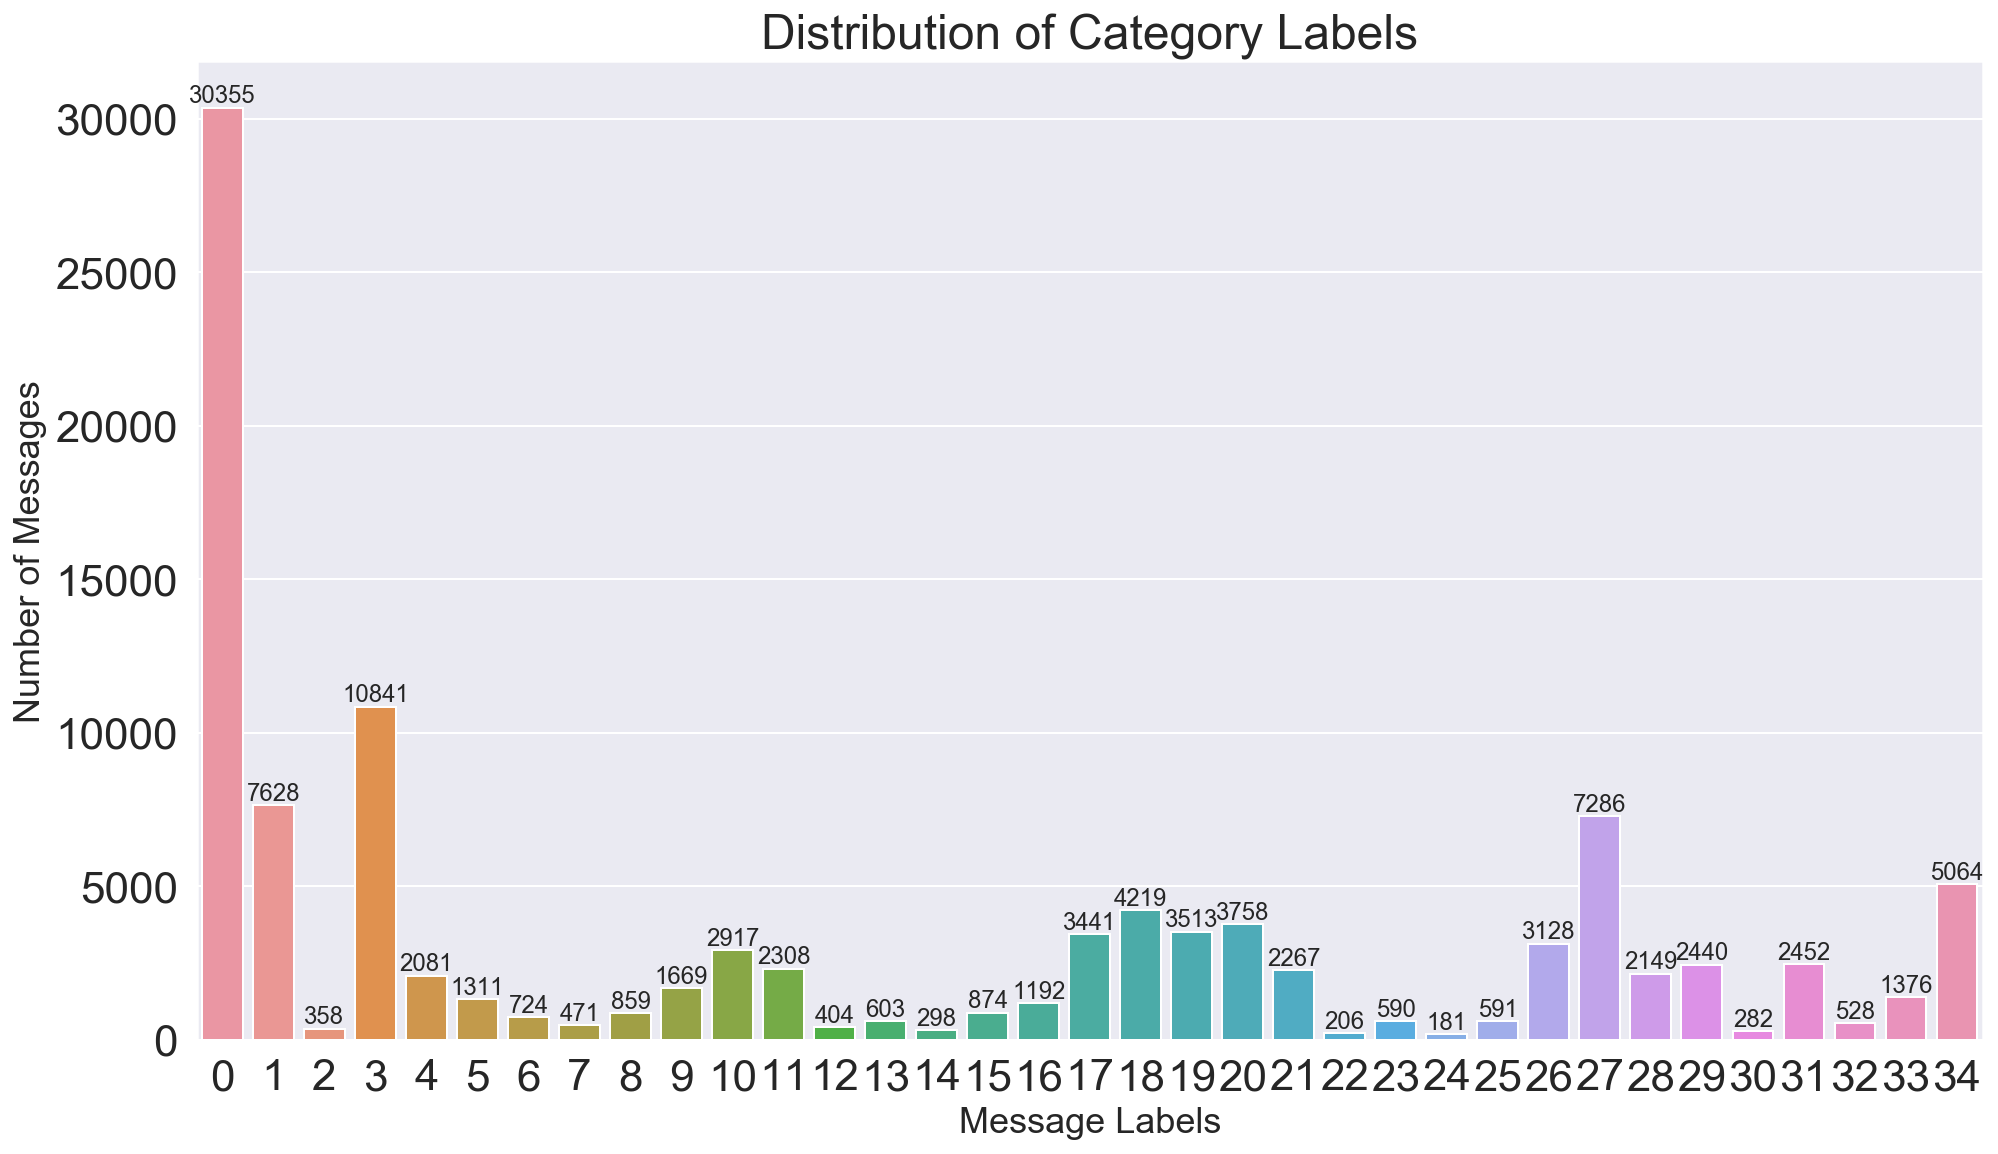

In [82]:
model_sample = ML_classifier(df_sample)
model_sample.plot_dist()

In [83]:
model_sample.fit()
model_sample.evaluate()

The Jaccard score on the test data set is: 0.5921334878009276


/Users/empyriumz/miniconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 in samples with no true or predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [84]:
report_sample = model_sample.report
report_sample[(report_sample['precision'] == 0.0) | (report_sample.index == 'macro avg')]

,precision,recall,f1-score,support
security,0.000000,0.000000,0.000000,92.0
missing_people,0.000000,0.000000,0.000000,61.0
macro avg,0.784234,0.382578,0.475692,21572.0


The more advanced sampling strategy works much better!

### 9. Export your model as a pickle file

### 10. Use this notebook to complete `train.py`
Use the template file attached in the Resources folder to write a script that runs the steps above to create a database and export a model based on a new dataset specified by the user.